In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix)
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

 Loading dataset...
 Loaded 7043 customer records.
Churn distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

 Final feature set: 30 features

 Training XGBoost model...



 Evaluation Metrics:
Accuracy:  0.8034
Precision: 0.6540
Recall:    0.5508
F1-Score:  0.5980
AUC-ROC:   0.8389

 Classification Report:
              precision    recall  f1-score   support

   Not Churn       0.85      0.89      0.87      1035
       Churn       0.65      0.55      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

 Confusion matrix saved as 'confusion_matrix_churn.png'
 Top feature importance plot saved as 'feature_importance.png'

 Model saved as 'model.pkl'

 Demo Prediction:
Customer → Prediction: Not Churn (Churn Probability: 0.2278)

 Task 3: Customer Churn Prediction completed successfully!


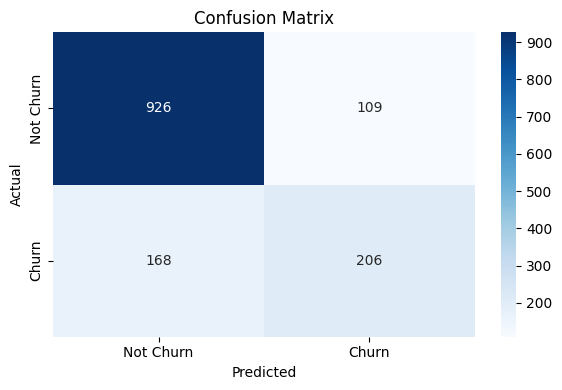

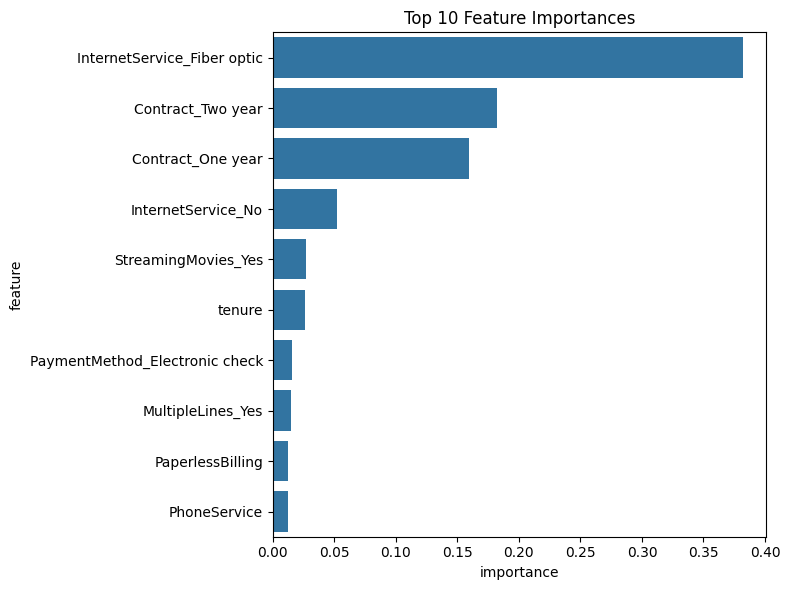

In [4]:
def main():
    
    dataset_path = 'WA_Fn-UseC_-Telco-Customer-Churn.csv'
    if not os.path.exists(dataset_path):
        print(" Error: 'churn.csv' not found.")
        print(" Download from: https://www.kaggle.com/datasets/blastchar/telco-customer-churn")
        print("Rename the file to 'churn.csv' and place it in:", os.getcwd())
        return

    print(" Loading dataset...")
    df = pd.read_csv(dataset_path)
    print(f" Loaded {len(df)} customer records.")
    print("Churn distribution:")
    print(df['Churn'].value_counts())

    df = df.drop('customerID', axis=1)

    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

    df_encoded = df.copy()

    binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    for col in binary_cols:
        df_encoded[col] = df_encoded[col].map({'Yes': 1, 'No': 0})

    categorical_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity',
                        'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
                        'StreamingMovies', 'Contract', 'PaymentMethod']

    df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True)

    X = df_encoded.drop('Churn', axis=1)
    y = df_encoded['Churn']

    print(f"\n Final feature set: {X.shape[1]} features")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print("\n Training XGBoost model...")
    model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    print("\n Evaluation Metrics:")
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_pred):.4f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
    print(f"F1-Score:  {f1_score(y_test, y_pred):.4f}")
    print(f"AUC-ROC:   {roc_auc_score(y_test, y_pred_proba):.4f}")

    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Not Churn', 'Churn']))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Churn', 'Churn'],
                yticklabels=['Not Churn', 'Churn'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig('confusion_matrix_churn.png')
    print(" Confusion matrix saved as 'confusion_matrix_churn.png'")

    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='importance', y='feature', data=importance.head(10))
    plt.title('Top 10 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print(" Top feature importance plot saved as 'feature_importance.png'")

    with open('model.pkl', 'wb') as f:
        pickle.dump(model, f)
    print("\n Model saved as 'model.pkl'")

    def predict_churn(customer_data_dict):
        """
        Input: dict with original column names and raw values (as in dataset)
        Output: (prediction, churn_probability)
        """
        demo_df = pd.DataFrame([customer_data_dict])
        demo_df = demo_df.drop('customerID', axis=1, errors='ignore')

        demo_df['TotalCharges'] = pd.to_numeric(demo_df['TotalCharges'], errors='coerce')
        if pd.isna(demo_df['TotalCharges'].iloc[0]):
            demo_df['TotalCharges'] = df['TotalCharges'].median()

        for col in ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']:
            demo_df[col] = demo_df[col].map({'Yes': 1, 'No': 0})

        demo_df = pd.get_dummies(demo_df, columns=categorical_cols, drop_first=True)

        for col in X.columns:
            if col not in demo_df.columns:
                demo_df[col] = 0
        demo_df = demo_df[X.columns]

        pred = model.predict(demo_df)[0]
        prob = model.predict_proba(demo_df)[0, 1]
        return "Churn" if pred == 1 else "Not Churn", prob

    sample_customer = {
        'gender': 'Female',
        'SeniorCitizen': 0,
        'Partner': 'Yes',
        'Dependents': 'No',
        'tenure': 10,
        'PhoneService': 'Yes',
        'MultipleLines': 'No',
        'InternetService': 'DSL',
        'OnlineSecurity': 'No',
        'OnlineBackup': 'Yes',
        'DeviceProtection': 'No',
        'TechSupport': 'No',
        'StreamingTV': 'No',
        'StreamingMovies': 'No',
        'Contract': 'Month-to-month',
        'PaperlessBilling': 'Yes',
        'PaymentMethod': 'Electronic check',
        'MonthlyCharges': 29.85,
        'TotalCharges': 29.85
    }

    label, prob = predict_churn(sample_customer)
    print(f"\n Demo Prediction:")
    print(f"Customer → Prediction: {label} (Churn Probability: {prob:.4f})")

    print("\n Task 3: Customer Churn Prediction completed successfully!")


if __name__ == "__main__":
    main()